In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd
import seaborn as sns

In [2]:
models = ["polished-donkey-996", "polar-lake-997", "still-deluge-998"]
dfsim = pd.concat([pd.read_pickle(f".cache_3/{model}.pkl") for model in models], ignore_index=True)

dfsim["location"] = "simulation"

In [3]:
dfmac = pd.read_pickle("machine_studies/summary_agentsoverproblems.pkl")
dfdrf = pd.read_pickle("machine_studies/summary_driftexperiments.pkl")
dflng = pd.read_pickle("machine_studies/summary_longrun.pkl")
dfopa = pd.read_pickle("machine_studies/summary_operatorsvsagents.pkl")

dfmac["location"] = "machine"

## Experiments Over Problems

In [12]:
dfpbl = pd.concat([dfsim,dfmac], ignore_index=True)

In [13]:
# Compute MAE
dfpbl["delta_mu_x"] = np.abs(dfpbl["mup_x"] - dfpbl["mu_x"])
dfpbl["delta_mu_y"] = np.abs(dfpbl["mup_y"] - dfpbl["mu_y"])
dfpbl["delta_sigma_x"] = np.abs(dfpbl["sigmap_x"] - dfpbl["sigma_x"])
dfpbl["delta_sigma_y"] = np.abs(dfpbl["sigmap_y"] - dfpbl["sigma_y"])
dfpbl["mae"] = (dfpbl["delta_mu_x"] + dfpbl["delta_mu_y"] + dfpbl["delta_sigma_x"] + dfpbl["delta_sigma_y"]) / 4

In [20]:
# Put together final outcomes (after max 30 steps)
finals = dfpbl[dfpbl["step"] <= 30]
finals = finals.groupby(["model","problem","location"]).apply(lambda x: x.loc[x["step"].idxmax()])
finals = finals.drop(["model","problem","location"], axis=1).reset_index()

In [45]:
# Get all problems evaluated on the machine (in machine and simulation version)
macprobidx = finals[finals["location"] == "machine"].set_index(["model","problem"]).index
onboth = finals.set_index(["model","problem"]).loc[macprobidx].reset_index()

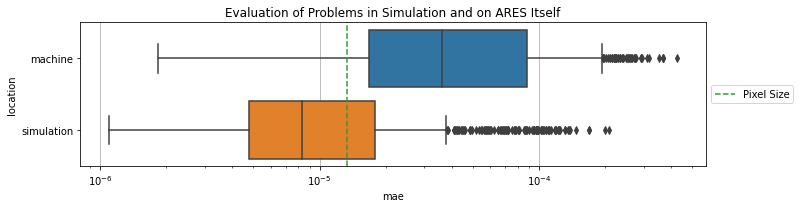

In [47]:
plt.figure(figsize=(10,3))
plt.title("Evaluation of Problems in Simulation and on ARES Itself")
sns.boxplot(x="mae", y="location", data=onboth)
plt.axvline(3.3198e-6*4, c="tab:green", ls="--", label="Pixel Size")  # Smaller pixel edge at binning=4
plt.xscale("log")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width*0.8, box.height])
plt.gca().legend(loc="center left", bbox_to_anchor=(1,0.5))
plt.tight_layout()
plt.show()

In [55]:
onbothsim = onboth[onboth["location"] == "simulation"].set_index(["model","problem"])
onbothmac = onboth[onboth["location"] == "machine"].set_index(["model","problem"])
maediffs = (onbothmac["mae"] - onbothsim["mae"]).reset_index()

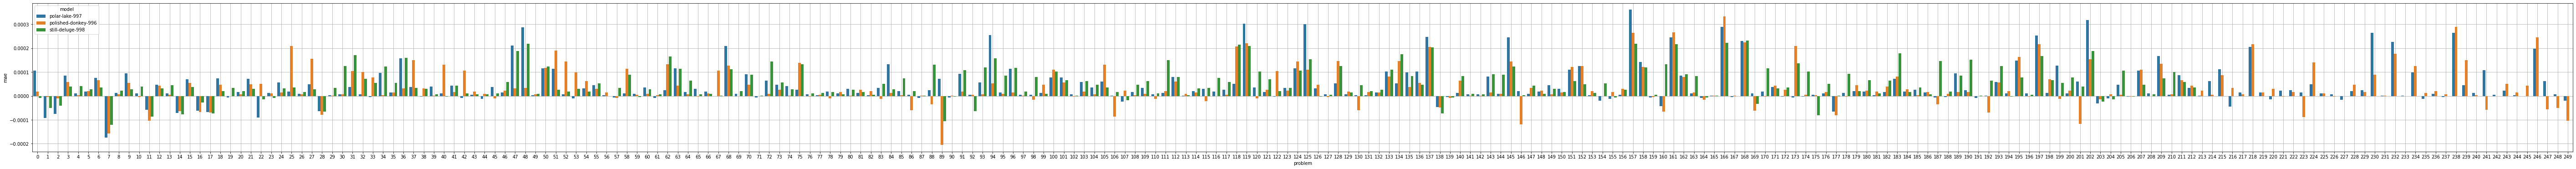

In [66]:
plt.figure(figsize=(100,6))
sns.barplot(x="problem", y="mae", hue="model", data=maediffs)
plt.grid()
plt.gca().set_axisbelow(True)
plt.show()

In [72]:
print(f"Is solution better in simulation? ({len(maediffs)} runs in total)")
(maediffs["mae"] >= 0).value_counts()

Is solution better in simulation? (713 runs in total)


True     576
False    137
Name: mae, dtype: int64

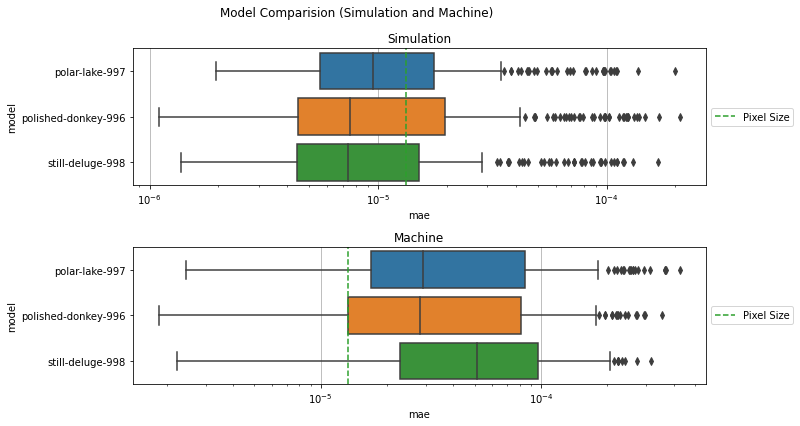

In [73]:
plt.figure(figsize=(10,6))
plt.suptitle("Model Comparision (Simulation and Machine)")
plt.subplot(211)
plt.title("Simulation")
sns.boxplot(x="mae", y="model", data=onboth[onboth["location"] == "simulation"])
plt.axvline(3.3198e-6*4, c="tab:green", ls="--", label="Pixel Size")  # Smaller pixel edge at binning=4
plt.xscale("log")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width*0.8, box.height])
plt.gca().legend(loc="center left", bbox_to_anchor=(1,0.5))
plt.subplot(212)
plt.title("Machine")
sns.boxplot(x="mae", y="model", data=onboth[onboth["location"] == "machine"])
plt.axvline(3.3198e-6*4, c="tab:green", ls="--", label="Pixel Size")  # Smaller pixel edge at binning=4
plt.xscale("log")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width*0.8, box.height])
plt.gca().legend(loc="center left", bbox_to_anchor=(1,0.5))
plt.tight_layout()
plt.show()

## Drift Study

In [242]:
filtered = dfdrf[dfdrf["model"] == "polished-donkey-996"].copy()

filtered.loc[filtered["comment"].isnull(),"comment"] = filtered.loc[filtered["comment"].isnull(),"date"].transform(lambda x: str(x))
filtered.loc[filtered["comment"] == "solenoid adjusted","comment"] = filtered.loc[filtered["comment"] == "solenoid adjusted","date"].transform(lambda x: str(x)) + " " + filtered.loc[filtered["comment"] == "solenoid adjusted","comment"]

In [243]:
tmp = filtered.loc[filtered["comment"] != "2021-12-09", "q3"].copy()
filtered.loc[filtered["comment"] != "2021-12-09", "q3"] = filtered.loc[filtered["comment"] != "2021-12-09", "cv"].copy()
filtered.loc[filtered["comment"] != "2021-12-09", "cv"] = tmp.copy()

In [244]:
# Compute MAE
filtered["delta_mu_x"] = np.abs(filtered["mup_x"] - filtered["mu_x"])
filtered["delta_mu_y"] = np.abs(filtered["mup_y"] - filtered["mu_y"])
filtered["delta_sigma_x"] = np.abs(filtered["sigmap_x"] - filtered["sigma_x"])
filtered["delta_sigma_y"] = np.abs(filtered["sigmap_y"] - filtered["sigma_y"])
filtered["mae"] = (filtered["delta_mu_x"] + filtered["delta_mu_y"] + filtered["delta_sigma_x"] + filtered["delta_sigma_y"]) / 4

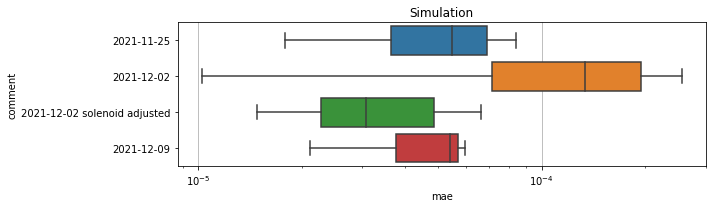

In [245]:
plt.figure(figsize=(10,3))
plt.title("Simulation")
sns.boxplot(x="mae", y="comment", data=filtered[filtered["step"] == 30])
plt.xscale("log")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()

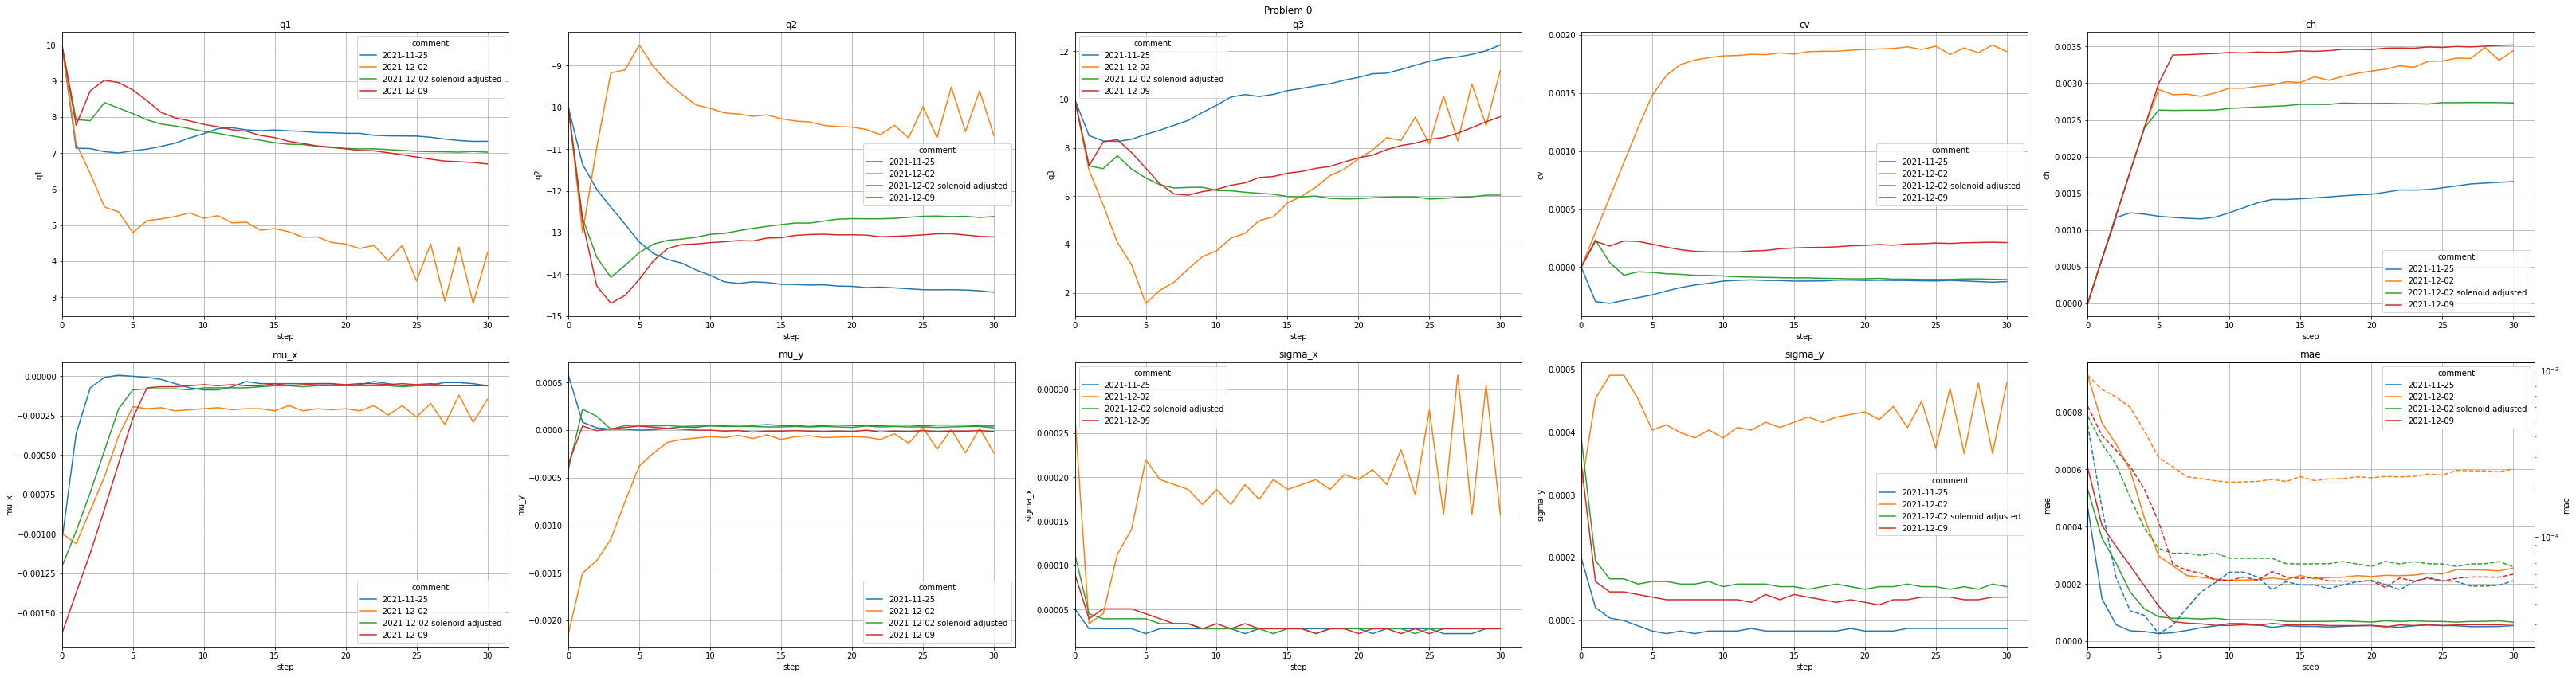

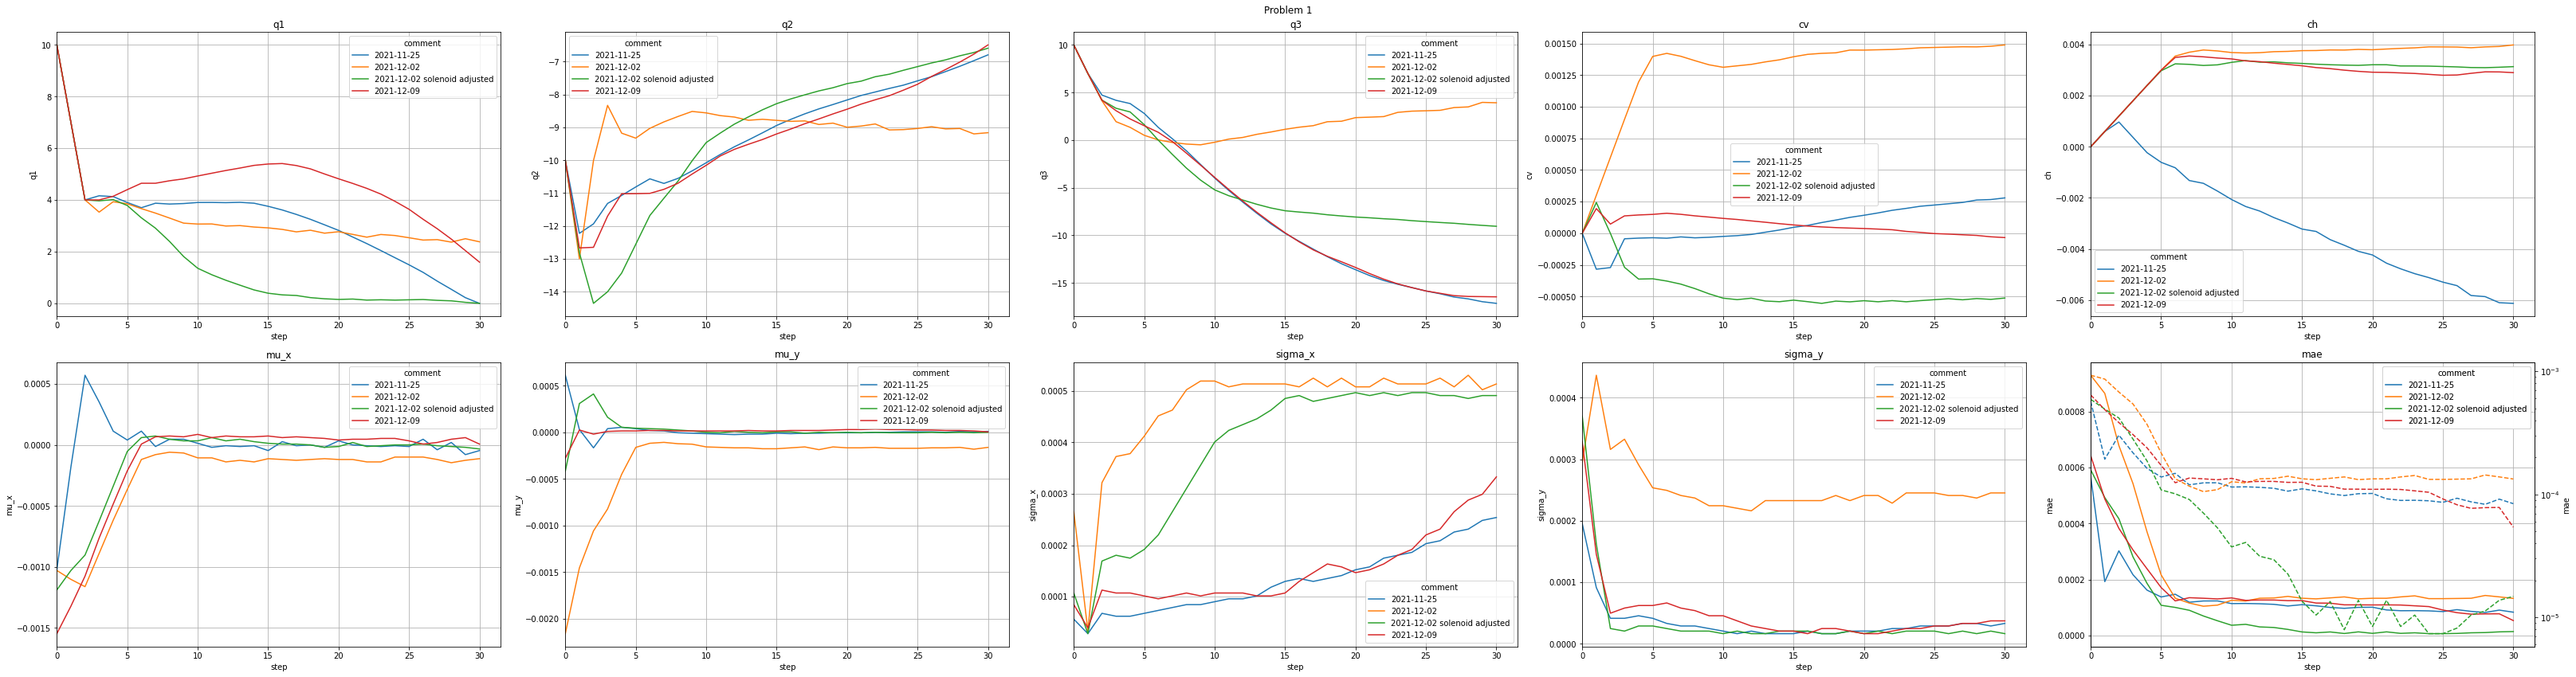

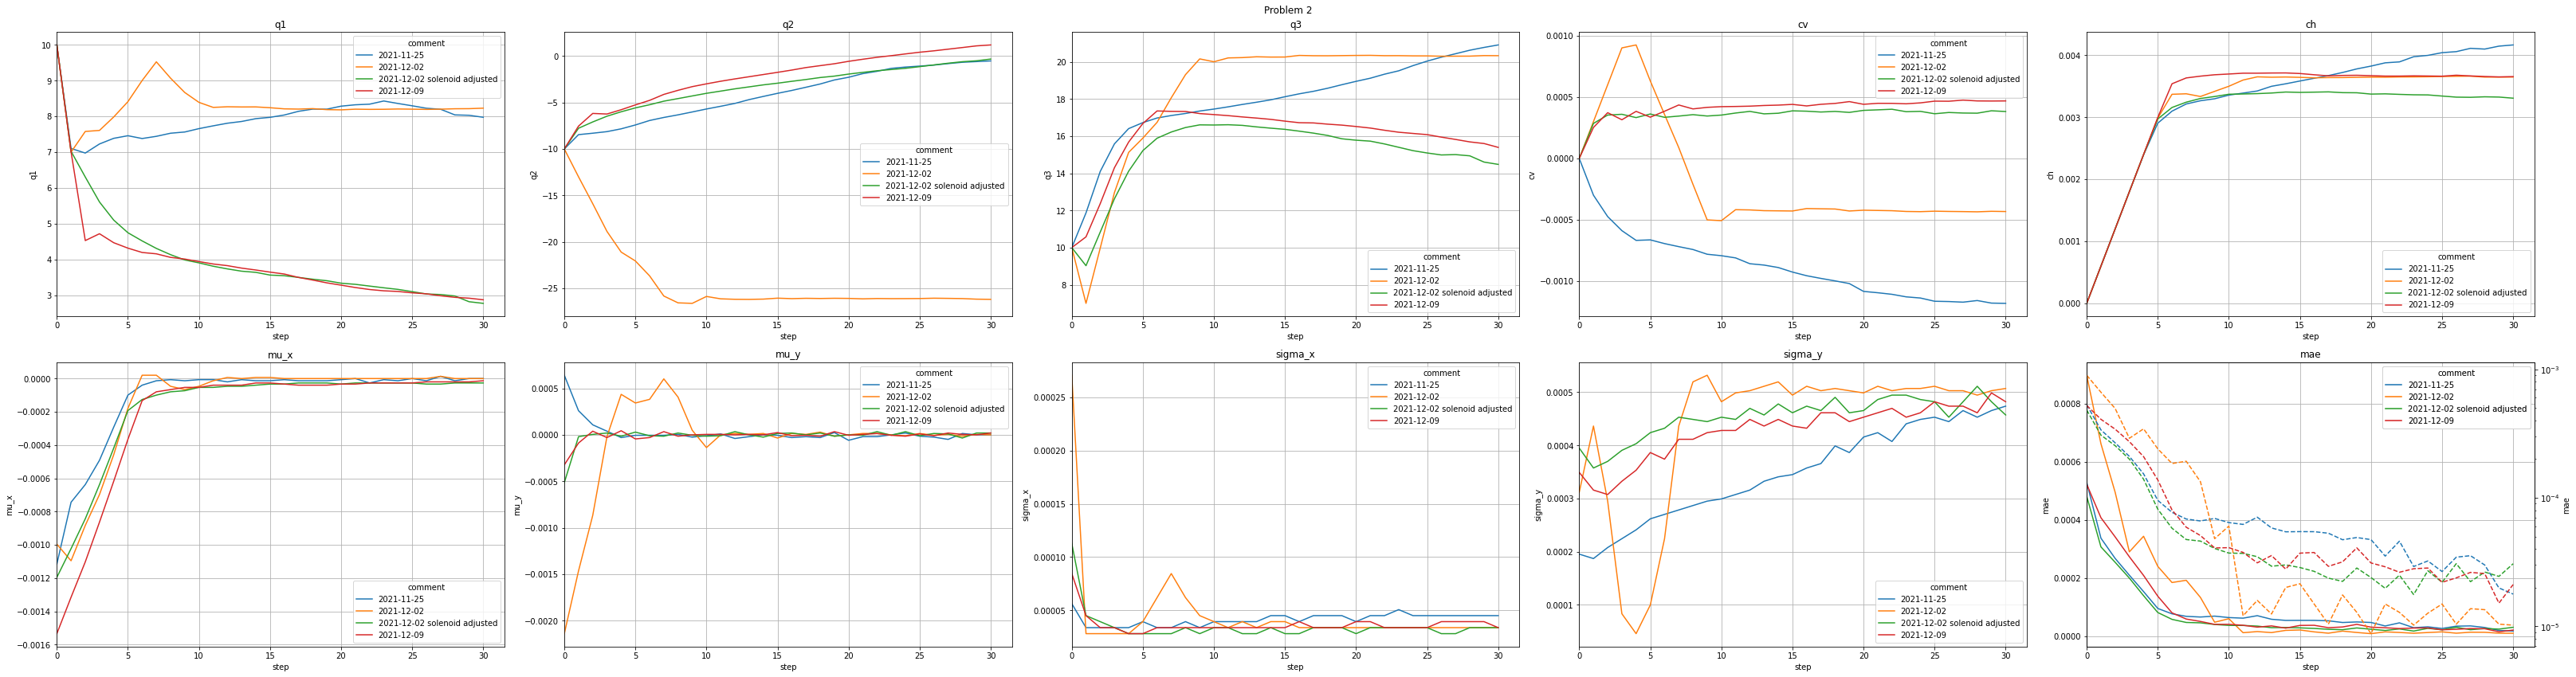

In [246]:
for problem in range(3):
    plt.figure(figsize=(45,12))
    plt.suptitle(f"Problem {problem}")
    for i, key in enumerate(["q1","q2","q3","cv","ch","mu_x","mu_y","sigma_x","sigma_y","mae"]):
        plt.subplot(2, 5, i+1)
        plt.title(key)
        sns.lineplot(x="step", y=key, hue="comment", data=filtered[filtered["problem"] == problem])
        plt.xlim(0, None)
        plt.grid()
        plt.gca().set_axisbelow(True)
        if key == "mae":
            ax2 = plt.twinx()
            sns.lineplot(x="step", y=key, hue="comment", ls="--", data=filtered[filtered["problem"] == problem], ax=ax2)
            plt.yscale("log")
    plt.tight_layout()
    plt.show()

## Long Run

In [155]:
# Compute MAE
dflng["delta_mu_x"] = np.abs(dflng["mup_x"] - dflng["mu_x"])
dflng["delta_mu_y"] = np.abs(dflng["mup_y"] - dflng["mu_y"])
dflng["delta_sigma_x"] = np.abs(dflng["sigmap_x"] - dflng["sigma_x"])
dflng["delta_sigma_y"] = np.abs(dflng["sigmap_y"] - dflng["sigma_y"])
dflng["mae"] = (dflng["delta_mu_x"] + dflng["delta_mu_y"] + dflng["delta_sigma_x"] + dflng["delta_sigma_y"]) / 4

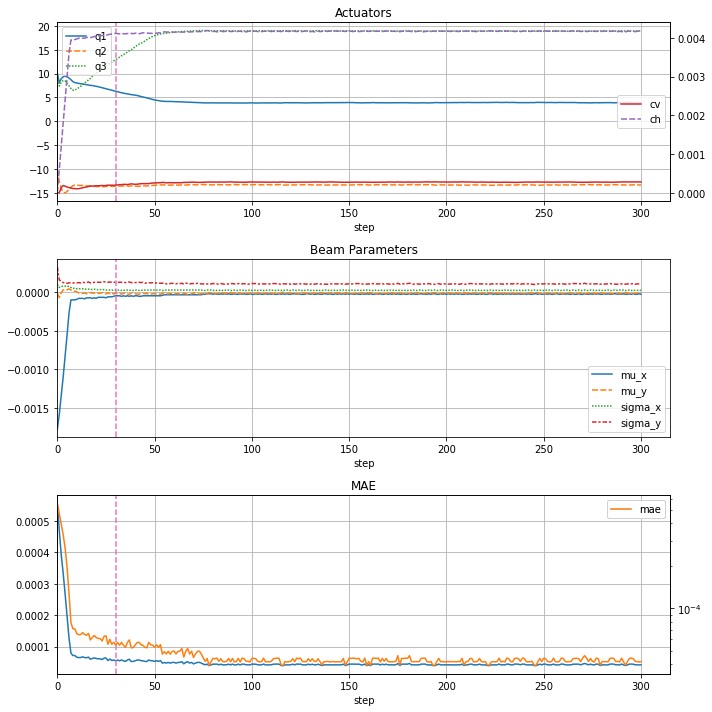

In [168]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
plt.title("Actuators")
sns.lineplot(data=dflng.set_index("step")[["q1","q2","q3"]])
plt.axvline(30, c="tab:pink", ls="--", label="Normal Max Steps")
plt.grid()
plt.gca().set_axisbelow(True)
ax2 = plt.twinx()
sns.lineplot(data=dflng.set_index("step")[["cv","ch"]], ax=ax2, hue_order=["","","","cv","ch"])
plt.xlim(0, None)
plt.subplot(312, sharex=ax1)
plt.title("Beam Parameters")
sns.lineplot(data=dflng.set_index("step")[["mu_x","mu_y","sigma_x","sigma_y"]])
plt.axvline(30, c="tab:pink", ls="--", label="Normal Max Steps")
plt.grid()
plt.gca().set_axisbelow(True)
plt.subplot(313, sharex=ax1)
plt.title("MAE")
sns.lineplot(data=dflng.set_index("step")[["mae"]])
plt.axvline(30, c="tab:pink", ls="--", label="Normal Max Steps")
plt.grid()
plt.gca().set_axisbelow(True)
ax2 = plt.twinx()
sns.lineplot(data=dflng.set_index("step")[["mae"]], ax=ax2, hue_order=["","mae"])
plt.yscale("log")
plt.tight_layout()
plt.show()

## Operators vs. Agents

In [95]:
hannes = dfopa[dfopa["model"] == "Hannes"].set_index("step").loc[100:2700].reset_index()
hannes["step"] = hannes["step"] - 100
willi = dfopa[dfopa["model"] == "Willi"].set_index("step").loc[185:2500].reset_index()
willi["step"] = willi["step"] - 185

polished_donkey = dfopa[dfopa["model"] == "polished-donkey-996"].copy()
polar_lake = dfopa[dfopa["model"] == "polar-lake-997"].copy()
still_deluge = dfopa[dfopa["model"] == "still-deluge-998"].copy()

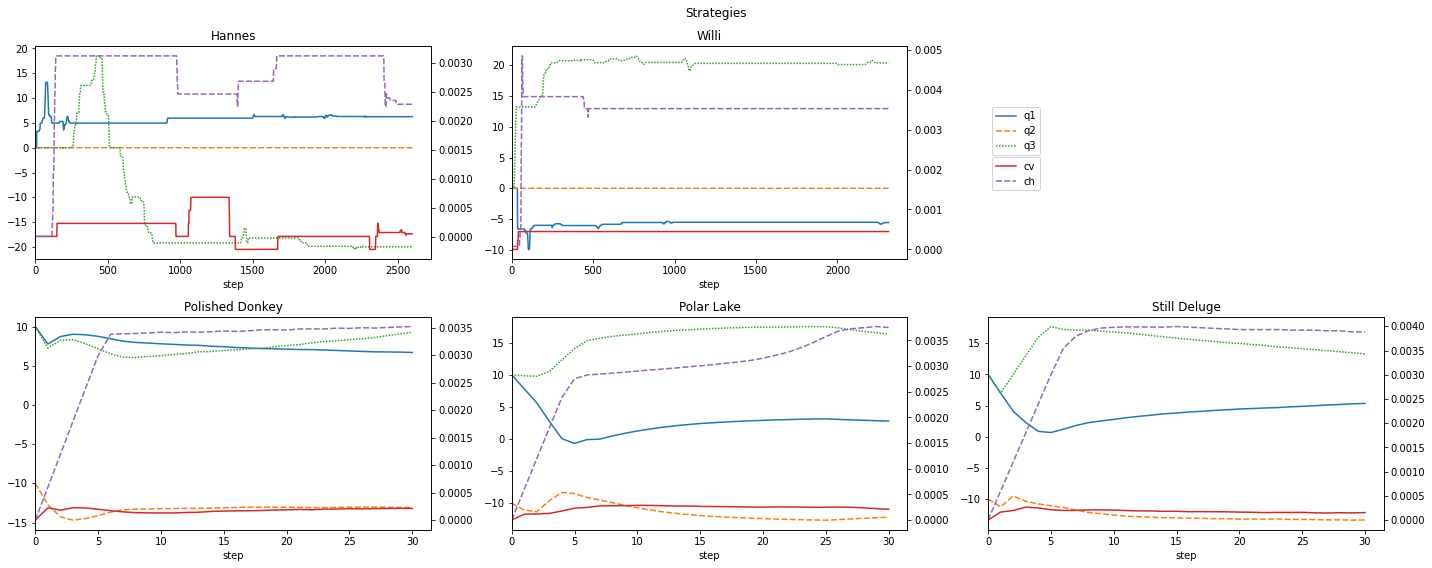

In [152]:
def actuator_plot(df, title=None, legend=True):
    plt.title(title)
    sns.lineplot(data=df.set_index("step")[["q1","q2","q3"]], legend=legend)
    if legend:
        box = plt.gca().get_position()
        plt.gca().set_position([box.x0, box.y0, box.width*0.8, box.height])
        plt.gca().legend(loc="center left", bbox_to_anchor=(1.2,0.6))
    ax2 = plt.twinx()
    sns.lineplot(data=df.set_index("step")[["cv","ch"]], ax=ax2, hue_order=["","","","cv","ch"], legend=legend)
    if legend:
        box = plt.gca().get_position()
        plt.gca().set_position([box.x0, box.y0, box.width*0.8, box.height])
        plt.gca().legend(loc="center left", bbox_to_anchor=(1.2,0.4))
    plt.xlim(0, None)

plt.figure(figsize=(20,8))
plt.suptitle("Strategies")
plt.subplot(231)
actuator_plot(hannes, title="Hannes", legend=False)
plt.subplot(232)
actuator_plot(willi, title="Willi", legend=True)
plt.subplot(234)
actuator_plot(polished_donkey, title="Polished Donkey", legend=False)
plt.subplot(235)
actuator_plot(polar_lake, title="Polar Lake", legend=False)
plt.subplot(236)
actuator_plot(still_deluge, title="Still Deluge", legend=False)
plt.tight_layout()
plt.show()

In [64]:
est_dtoper = 0.5
est_dtagent = 10

hannes["estimated_t"] = hannes["step"] * est_dtoper
willi["estimated_t"] = willi["step"] * est_dtoper
polished_donkey["estimated_t"] = polished_donkey["step"] * est_dtagent
polar_lake["estimated_t"] = polar_lake["step"] * est_dtagent
still_deluge["estimated_t"] = still_deluge["step"] * est_dtagent

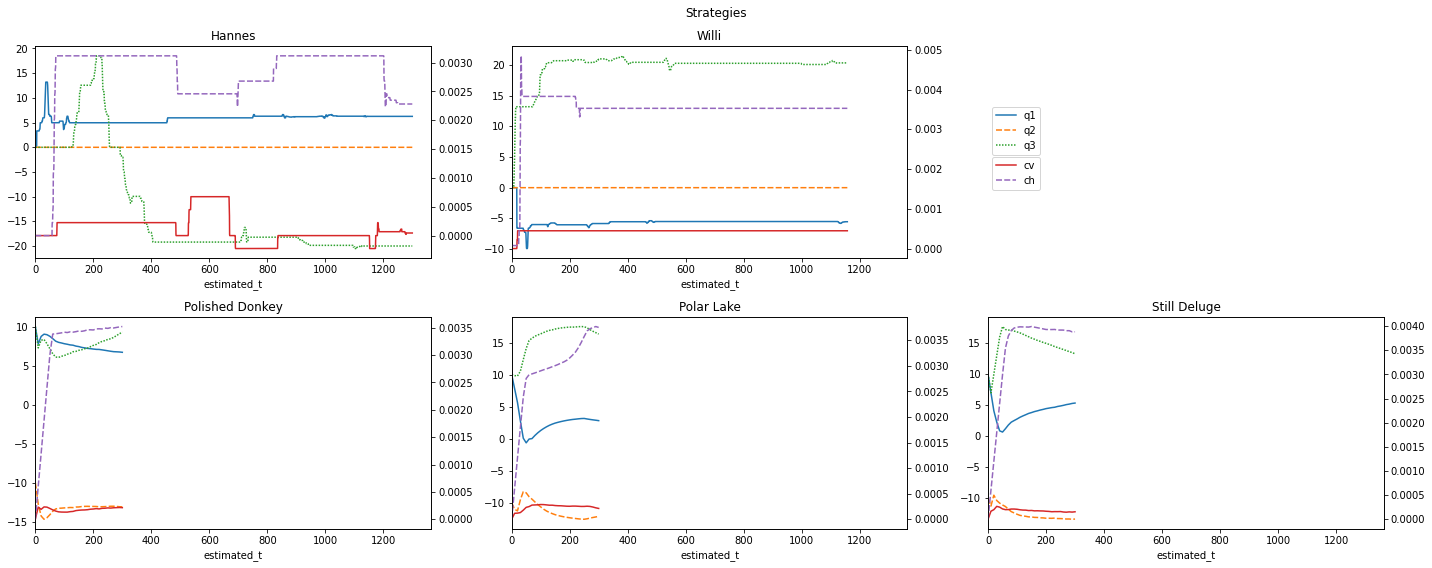

In [66]:
def actuator_plot(df, title=None, legend=True):
    plt.title(title)
    sns.lineplot(data=df.set_index("estimated_t")[["q1","q2","q3"]], legend=legend)
    if legend:
        box = plt.gca().get_position()
        plt.gca().set_position([box.x0, box.y0, box.width*0.8, box.height])
        plt.gca().legend(loc="center left", bbox_to_anchor=(1.2,0.6))
    ax2 = plt.twinx()
    sns.lineplot(data=df.set_index("estimated_t")[["cv","ch"]], ax=ax2, hue_order=["","","","cv","ch"], legend=legend)
    if legend:
        box = plt.gca().get_position()
        plt.gca().set_position([box.x0, box.y0, box.width*0.8, box.height])
        plt.gca().legend(loc="center left", bbox_to_anchor=(1.2,0.4))

plt.figure(figsize=(20,8))
plt.suptitle("Strategies")
ax1 = plt.subplot(231)
actuator_plot(hannes, title="Hannes", legend=False)
plt.xlim([0,None])
plt.subplot(232, sharex=ax1)
actuator_plot(willi, title="Willi", legend=True)
plt.subplot(234, sharex=ax1)
actuator_plot(polished_donkey, title="Polished Donkey", legend=False)
plt.subplot(235, sharex=ax1)
actuator_plot(polar_lake, title="Polar Lake", legend=False)
plt.subplot(236, sharex=ax1)
actuator_plot(still_deluge, title="Still Deluge", legend=False)
plt.tight_layout()
plt.show()

In [82]:
# Compute MAE
for df in [polished_donkey, polar_lake, still_deluge]:
    df["delta_mu_x"] = np.abs(df["mup_x"] - df["mu_x"])
    df["delta_mu_y"] = np.abs(df["mup_y"] - df["mu_y"])
    df["delta_sigma_x"] = np.abs(df["sigmap_x"] - df["sigma_x"])
    df["delta_sigma_y"] = np.abs(df["sigmap_y"] - df["sigma_y"])
    df["mae"] = (df["delta_mu_x"] + df["delta_mu_y"] + df["delta_sigma_x"] + df["delta_sigma_y"]) / 4

for df, name in zip([polished_donkey,polar_lake,still_deluge], ["polished_donkey","polar_lake","still_deluge"]):
    df[name] = df["mae"]

agent_maes = pd.concat([
    polished_donkey.set_index("step")["polished_donkey"],
    polar_lake.set_index("step")["polar_lake"],
    still_deluge.set_index("step")["still_deluge"]
], axis=1)

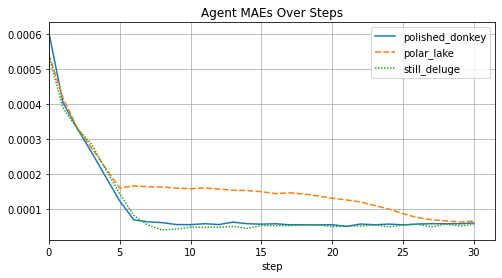

In [153]:
plt.figure(figsize=(8,4))
plt.title("Agent MAEs Over Steps")
sns.lineplot(data=agent_maes)
plt.xlim(0, None)
plt.grid()
plt.gca().set_axisbelow(True)
plt.show()

In [99]:
maxstep = hannes["step"].max()
hannes.set_index("step", inplace=True)
hannes.loc[maxstep,"mu_x"] = 0.01328 * 1e-3
hannes.loc[maxstep,"mu_y"] = 0.03915 * 1e-3
hannes.loc[maxstep,"sigma_x"] = 0.06766 * 1e-3
hannes.loc[maxstep,"sigma_y"] = 0.01662 * 1e-3
hannes.reset_index(inplace=True)

maxstep = willi["step"].max()
willi.set_index("step", inplace=True)
willi.loc[maxstep,"mu_x"] = -0.09295 * 1e-3
willi.loc[maxstep,"mu_y"] = -0.00979 * 1e-3
willi.loc[maxstep,"sigma_x"] = 0.04511 * 1e-3
willi.loc[maxstep,"sigma_y"] = 0.02494 * 1e-3
willi.reset_index(inplace=True)

In [103]:
# Compute MAE
for df in [hannes, willi]:
    df["delta_mu_x"] = np.abs(df["mup_x"] - df["mu_x"])
    df["delta_mu_y"] = np.abs(df["mup_y"] - df["mu_y"])
    df["delta_sigma_x"] = np.abs(df["sigmap_x"] - df["sigma_x"])
    df["delta_sigma_y"] = np.abs(df["sigmap_y"] - df["sigma_y"])
    df["mae"] = (df["delta_mu_x"] + df["delta_mu_y"] + df["delta_sigma_x"] + df["delta_sigma_y"]) / 4

for df, name in zip([hannes,willi], ["hannes","willi"]):
    df[name] = df["mae"]

operator_maes = pd.concat([
    hannes.set_index("step")["hannes"],
    willi.set_index("step")["willi"]
], axis=1)

In [111]:
operator_final_maes = {
    "hannes": operator_maes["hannes"][operator_maes["hannes"].notnull()].squeeze(),
    "willi": operator_maes["willi"][operator_maes["willi"].notnull()].squeeze()
}
operator_final_maes

{'hannes': 3.41775e-05, 'willi': 4.319750000000001e-05}

In [114]:
final_maes = agent_maes.loc[30].copy()
final_maes.loc["hannes"] = operator_final_maes["hannes"]
final_maes.loc["willi"] = operator_final_maes["willi"]
final_maes

polished_donkey    0.000060
polar_lake         0.000065
still_deluge       0.000057
hannes             0.000034
willi              0.000043
Name: 30, dtype: float64

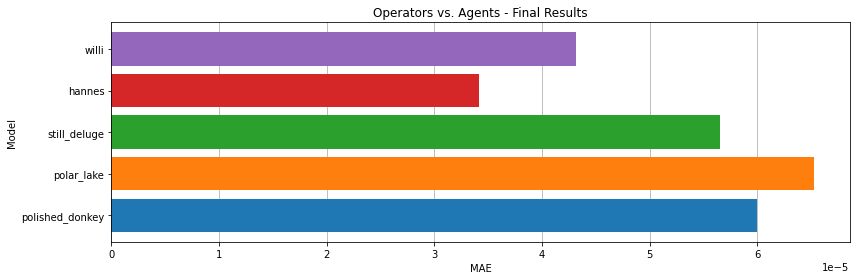

In [134]:
plt.figure(figsize=(12,4))
plt.title("Operators vs. Agents - Final Results")
plt.barh(y=final_maes.index, width=final_maes, color=["tab:blue","tab:orange","tab:green","tab:red","tab:purple"])
plt.xlabel("MAE")
plt.ylabel("Model")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()

In [147]:
final_beams = final_maes.copy()
final_beams = final_beams.to_frame()
final_beams.rename(columns={30: "mae"}, inplace=True)
final_beams.loc["hannes","mu_x"] = hannes[hannes["step"] == hannes["step"].max()]["mu_x"].squeeze()
final_beams.loc["hannes","mu_y"] = hannes[hannes["step"] == hannes["step"].max()]["mu_y"].squeeze()
final_beams.loc["hannes","sigma_x"] = hannes[hannes["step"] == hannes["step"].max()]["sigma_x"].squeeze()
final_beams.loc["hannes","sigma_y"] = hannes[hannes["step"] == hannes["step"].max()]["sigma_y"].squeeze()
final_beams.loc["willi","mu_x"] = willi[willi["step"] == willi["step"].max()]["mu_x"].squeeze()
final_beams.loc["willi","mu_y"] = willi[willi["step"] == willi["step"].max()]["mu_y"].squeeze()
final_beams.loc["willi","sigma_x"] = willi[willi["step"] == willi["step"].max()]["sigma_x"].squeeze()
final_beams.loc["willi","sigma_y"] = willi[willi["step"] == willi["step"].max()]["sigma_y"].squeeze()
final_beams.loc["polished_donkey","mu_x"] = polished_donkey[polished_donkey["step"] == 30]["mu_x"].squeeze()
final_beams.loc["polished_donkey","mu_y"] = polished_donkey[polished_donkey["step"] == 30]["mu_y"].squeeze()
final_beams.loc["polished_donkey","sigma_x"] = polished_donkey[polished_donkey["step"] == 30]["sigma_x"].squeeze()
final_beams.loc["polished_donkey","sigma_y"] = polished_donkey[polished_donkey["step"] == 30]["sigma_y"].squeeze()
final_beams.loc["polar_lake","mu_x"] = polar_lake[polar_lake["step"] == 30]["mu_x"].squeeze()
final_beams.loc["polar_lake","mu_y"] = polar_lake[polar_lake["step"] == 30]["mu_y"].squeeze()
final_beams.loc["polar_lake","sigma_x"] = polar_lake[polar_lake["step"] == 30]["sigma_x"].squeeze()
final_beams.loc["polar_lake","sigma_y"] = polar_lake[polar_lake["step"] == 30]["sigma_y"].squeeze()
final_beams.loc["still_deluge","mu_x"] = still_deluge[still_deluge["step"] == 30]["mu_x"].squeeze()
final_beams.loc["still_deluge","mu_y"] = still_deluge[still_deluge["step"] == 30]["mu_y"].squeeze()
final_beams.loc["still_deluge","sigma_x"] = still_deluge[still_deluge["step"] == 30]["sigma_x"].squeeze()
final_beams.loc["still_deluge","sigma_y"] = still_deluge[still_deluge["step"] == 30]["sigma_y"].squeeze()

final_beams

,mae,mu_x,mu_y,sigma_x,sigma_y
polished_donkey,0.000060,-0.000060,-0.000015,0.000028,0.000137
polar_lake,0.000065,-0.000073,0.000029,0.000051,0.000108
still_deluge,0.000057,0.000040,0.000020,0.000034,0.000133
hannes,0.000034,0.000013,0.000039,0.000068,0.000017
willi,0.000043,-0.000093,-0.000010,0.000045,0.000025


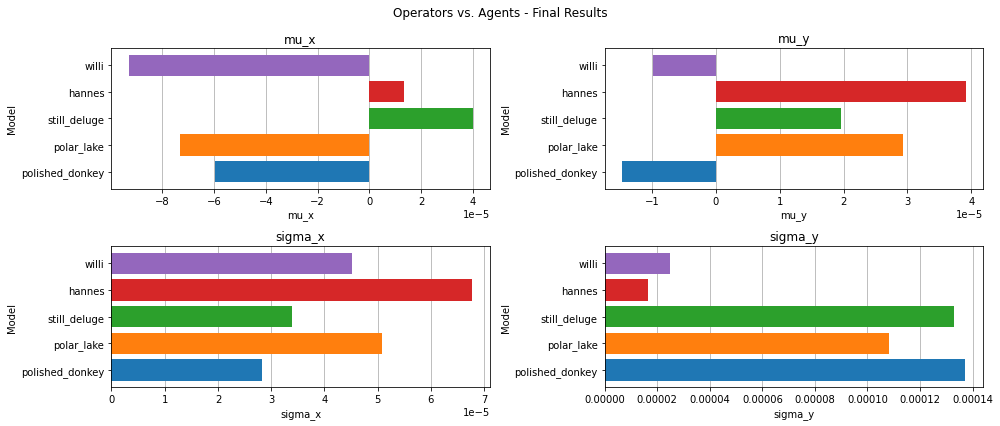

In [151]:
plt.figure(figsize=(14,6))
plt.suptitle("Operators vs. Agents - Final Results")
plt.subplot(221)
plt.title("mu_x")
plt.barh(y=final_beams.index, width=final_beams["mu_x"], color=["tab:blue","tab:orange","tab:green","tab:red","tab:purple"])
plt.xlabel("mu_x")
plt.ylabel("Model")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.subplot(222)
plt.title("mu_y")
plt.barh(y=final_beams.index, width=final_beams["mu_y"], color=["tab:blue","tab:orange","tab:green","tab:red","tab:purple"])
plt.xlabel("mu_y")
plt.ylabel("Model")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.subplot(223)
plt.title("sigma_x")
plt.barh(y=final_beams.index, width=final_beams["sigma_x"], color=["tab:blue","tab:orange","tab:green","tab:red","tab:purple"])
plt.xlabel("sigma_x")
plt.ylabel("Model")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.subplot(224)
plt.title("sigma_y")
plt.barh(y=final_beams.index, width=final_beams["sigma_y"], color=["tab:blue","tab:orange","tab:green","tab:red","tab:purple"])
plt.xlabel("sigma_y")
plt.ylabel("Model")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()